 ---
# i . Perkenalan

- **Nama     : Nurdin Atid Hidayatullah**
- **Dataset  : [Twitter Tweets Sentiment Dataset](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset)**

---

**Rumusan Masalah**

Media sosial, terutama Twitter, telah menjadi platform yang sangat populer untuk berbagi pendapat, berita, dan pengalaman sehari-hari. Jutaan tweet diposting setiap harinya, mencakup berbagai topik dan perasaan. Analisis sentimen pada data Twitter dapat memberikan wawasan yang berharga dalam memahami perasaan dan opini publik terhadap suatu topik yang sedang di perbincangkan. untuk itu dubutuhkan machine learning yang bisa mengartikan apakah coment pada topik tersebut bersifat negative, neutral atau positive.

---

**Solusi**

Dalam konteks ini, analisis sentimen menggunakan Natural Language Processing (NLP) menjadi pendekatan yang efektif untuk mengekstrak dan memahami sentimen di balik kata-kata yang digunakan dalam tweet. Oleh karena itu, penelitian ini bertujuan untuk melakukan analisis sentimen terhadap data Twitter dengan menggunakan teknik NLP.

---

# ii. Import Library

Import library yang diperlukan

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and machine learning libraries
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from wordcloud import WordCloud

# TensorFlow and Keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Bidirectional, Reshape, TextVectorization,
    LSTM, Embedding, Dropout, BatchNormalization
)
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import word_tokenize
import shutil
import os
from google.colab import files

# Download NLTK data for tokenization
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Instal Kaggle
!pip install kaggle

# iii. Data Loading

In [4]:
# Buat folder caggle
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# copy caggle jason ke new folder
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle

In [6]:
!kaggle datasets download -d yasserh/twitter-tweets-sentiment-dataset

twitter-tweets-sentiment-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Unzip Dataset
!unzip -q '/content/twitter-tweets-sentiment-dataset.zip' -d dataset

replace dataset/Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
# define data_path
data_path = '/content/dataset/Tweets.csv'

In [9]:
# read data set
df = pd.read_csv(data_path)

In [10]:
# Tampilkan Data lima teratas
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


The model we build is a model for detecting spam comments so we only need the 'sentiment' and 'text' columns

In [11]:
# ambil kolom yang dibutuhkan
df=df[['text','sentiment']]

In [12]:
# Tampilkan data teratas
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [13]:
# Tampilkan Informasi df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


Dari data set kita menggunakan dua kolom yaitu kolom test dan sentiment dengan type object dengan 27.481 baris data.


fullname |	description |
---------|--------------|
textID |	A unique text Id|
text	| The text of the tweet|
selected_text	| The selected text from tweet|
sentiment	| Sentiment of the tweet|


In [14]:
# Tampilkan distribusi sentiment
df["sentiment"].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

## 1. Text Processing

Dalam tahap ini akan dilakukan
- Missing value handling
- merapihkan data dari singkatan
- Merapihkan susunan teks
- mengganti target menjadi numerik

## a. Missing Value Handling
Dalam Tahap ini kita akan melakukan pembersihan data dari missing value.

In [15]:
# Memeriksa nilai yang hilang dalam setiap kolom
missing_values = df.isnull().sum()

# Menampilkan jumlah nilai yang hilang dalam setiap kolom
missing_values

text         1
sentiment    0
dtype: int64

In [16]:
# menhapus missing value
df = df.dropna()

In [17]:
# Memeriksa nilai yang hilang dalam setiap kolom
missing_values = df.isnull().sum()

# Menampilkan jumlah nilai yang hilang dalam setiap kolom
missing_values

text         0
sentiment    0
dtype: int64

Missing Value berhasil di handling hingga sudah tidak ada lagi missing Value

## b. Merapihkan Chat dari Singkatan


Pada bagian ini kita akan melakukan penghapusan dan perubahan kata pada data kita
Sebelumnya kita buat dulu list singkatan yang akan kita ubah list ini diambil dari [Up-to-date list of Slangs for Text Preprocessing](https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/notebook)


In [18]:
# list singkatan
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

Setiap text yang berbentuk singkatan yang di deskripsikan oleh data di atas akan ter ektract menjadi susuanan yang benar.

## c. Merapihkan Susunan Teks

Pada bagian ini Selanjutnya kita akan membuat fungsi yang akan mengubah data kita.

Pada fungsi tersebut data teks akan:

- diubah menjadi huruf kecil
- menghilangkan \n
- menghilangkan whitespace
- menghilangkan link
- menghilangkan simbol
- menghilangkan stopword
- mengubah singkatan/slang
- melakukan steeming

In [19]:
# buat fungsi
def text_proses(teks):
  # mengubah ke lowercase
  teks = teks.lower()

    # menghilangkan \n
  teks = re.sub(r"\n", " ",teks)

  # menghilangkan whitespace
  teks = teks.strip()

  # menghilangkan link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # menghilangkan simbol
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # tokenisasi
  tokens = word_tokenize(teks)

  # stopwords
  stop_words = set(stopwords.words('english'))
  teks = ' '.join([word for word in tokens if word not in stop_words])

  # mengubah singkatan
  teks = ' '.join(abbreviations.get(word, word) for word in teks.split())

  lemmatizer = WordNetLemmatizer()
  teks = lemmatizer.lemmatize(teks)

  # stemming
  stemmer = PorterStemmer()
  # teks = stemmer.stem(teks)

  return teks

Fungsi tersebut kemudian kita terapkan pada kolom 'text'

In [20]:
# membuat kolom baru dengan hasil dari kolom text yang sudah di rapihkan
df['text_PROCESSED'] = df['text'].apply(lambda x: text_proses(x))

In [21]:
# Tampilkan Seluruh kolom df
df

,text,sentiment,text_PROCESSED
0,"I`d have responded, if I were going",neutral,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,boss bullying
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,sons put releases already bought
...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,wish could come see you denver husband lost jo...
27477,I`ve wondered about rake to. The client has ...,negative,wondered rake client made clear net force devs...
27478,Yay good for both of you. Enjoy the break - y...,positive,yay good enjoy break probably need hectic week...
27479,But it was worth it ****.,positive,worth


## 2. Target Conversion

Dari bagian ini kita akan mengconfersi target dari yang awal berbentuk negatif, netral dan positif.
kita ubah dengan susunan :
- negative = 0,
- neutral = 1,
- positif = 2.

In [22]:
# Tampilkan uniq value pada kolom sentiment
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [23]:
# Ubah target menjadi nomor
df['label'] = df['sentiment'].replace({'negative' : 0, 'neutral' : 1, 'positive' : 2})
df

,text,sentiment,text_PROCESSED,label
0,"I`d have responded, if I were going",neutral,responded going,1
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego,0
2,my boss is bullying me...,negative,boss bullying,0
3,what interview! leave me alone,negative,interview leave alone,0
4,"Sons of ****, why couldn`t they put them on t...",negative,sons put releases already bought,0
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,wish could come see you denver husband lost jo...,0
27477,I`ve wondered about rake to. The client has ...,negative,wondered rake client made clear net force devs...,0
27478,Yay good for both of you. Enjoy the break - y...,positive,yay good enjoy break probably need hectic week...,2
27479,But it was worth it ****.,positive,worth,2


Target sudah berbentuk angka dalam hal ini penting dan perlu di lakukan agar saat training dapat berjalan.

# iv. Exploratory Data Analysis  (EDA)

Pada bagian ini kita akan mencarit tau
- Berapa banyak persebaran antara sentiment negative, neutral dan positif
- Menampilkan dalam word cloud kata apa saja yang sering muncul dalam sentiment negative, neutral dan positif.

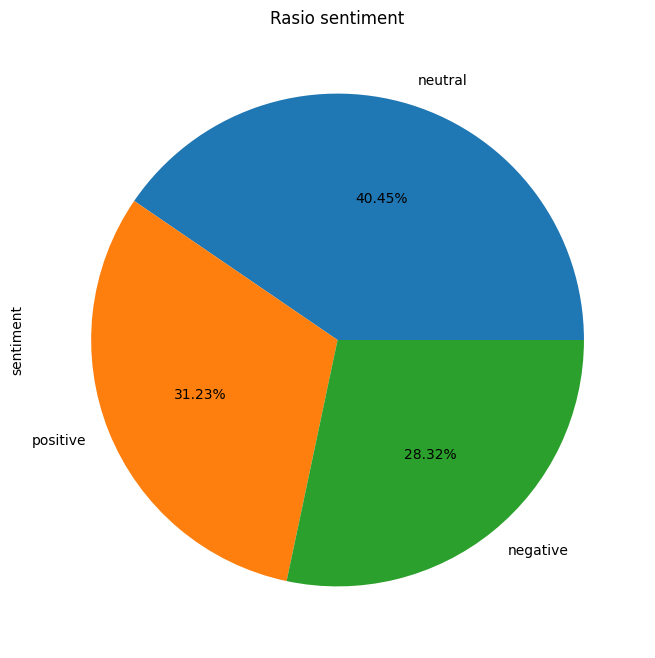

In [24]:
# Membuat Pie Chart
fig,ax1 = plt.subplots(figsize=(8,8))

df['sentiment'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)
plt.title('Rasio sentiment')
plt.show()

Dari pai chart diatas dari seluruh data dapat kita simpulkan
- sentiment negative =  28.32 %
- sentiment positive = 31.23 %
- sentiment neutral = 40.45%

In [25]:
# Membuat word cloud untuk sentimen positif
positive_text = ' '.join(df[df['sentiment'] == 'positive']['text_PROCESSED'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Membuat word cloud untuk sentimen negatif
negative_text = ' '.join(df[df['sentiment'] == 'negative']['text_PROCESSED'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Membuat word cloud untuk sentimen netral
neutral_text = ' '.join(df[df['sentiment'] == 'neutral']['text_PROCESSED'])
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)


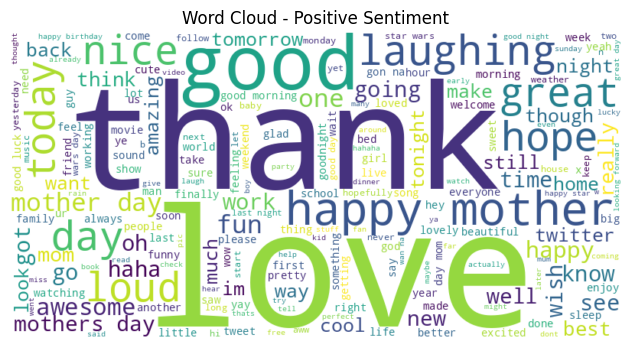

In [26]:
# Menampilkan word cloud
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()

Dalam sentiment positif kata yang paling banyak muncul adalah : thank, love, happy, good dll

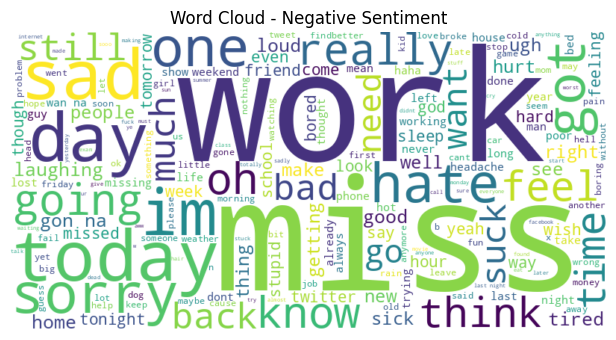

In [27]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')


plt.tight_layout()
plt.show()

Dalam sentiment negatif kata yang sering muncul adalah : work, hate, miss, sad, suck dll

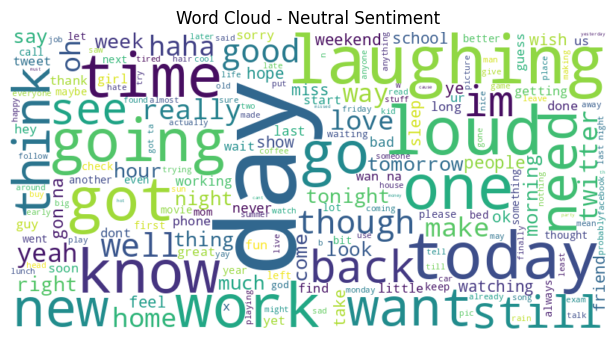

In [28]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud - Neutral Sentiment')
plt.axis('off')
plt.tight_layout()
plt.show()

Dalam sentimen netral kata kata yang sering muncul adalah day, one, new, time. today dll

# v. Feature Enginering

Simpan data untuk kemudian nanti dijadikan sebagai bahan prediksi

In [29]:
# menyimpan 1 data acak dari data asli untuk dijadikan inferensi data ke dalam variabel data_inf
data_inf = df.sample(1, random_state=40)

# hapus inferensi data dari df
df.drop(data_inf.index, inplace=True)

# reset indeks untuk data_inf dan df
df.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

data_inf.to_csv('data_inf.csv',index=False)

Split X dan y

In [30]:
# membagi data fitur dan target
X=df['text_PROCESSED']
y=df['label']

Cek distribusi dalam label

In [31]:
# Target Distribution
df['label'].value_counts()

1    11117
2     8582
0     7780
Name: label, dtype: int64

dari hasil pengecekan distribusi terlihat
- komen 1 (netral) sebanyak 11.117,
- komen 2 (positive) sebanyak 8.582,
- komen 0 (Negative) sebanyak 7.780

Selanjutnya kita akan melakukan prose pembagian antara X_train, X_test, dan X_Val.

In [32]:
# memisahkan df

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_PROCESSED,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (21021,)
Val Size   :  (2336,)
Test Size  :  (4122,)


Hasil dari split kita dapatkan
- X_train  :  21021
- X_val    :   2336
- X_test   :   4122

Encoding

In [33]:
# Merubah Target menjadi One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# vi - Model Definition

### a. Text Vectorization

In [34]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<21021x19999 sparse matrix of type '<class 'numpy.int64'>'
	with 144609 stored elements in Compressed Sparse Row format>

In [35]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  19999
Maximum Sentence Length :  27 tokens


In [36]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [37]:
# Example Result

## Document example
print('Document example')
print(df.text_PROCESSED[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.text_PROCESSED[0]]))
print('Vector size : ', text_vectorization([df.text_PROCESSED[0]]).shape)

Document example
responded going

Result of Text Vectorization
tf.Tensor(
[[ 1 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]], shape=(1, 27), dtype=int64)
Vector size :  (1, 27)


In [38]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'got',
 'today',
 'love',
 'work',
 'going',
 'laughing',
 'loud',
 'you',
 'out',
 'one',
 'time',
 'know',
 'happy']

### b. Word Embedding

In [39]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [40]:
# Example Result

## Document example
print('Document example')
print(df.text_PROCESSED[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.text_PROCESSED[0]]))
print('Vector size : ', text_vectorization([df.text_PROCESSED[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.text_PROCESSED[0]])))
print('Vector size : ', embedding(text_vectorization([df.text_PROCESSED[0]])).shape)

Document example
responded going

Result of  Text Vectorization
tf.Tensor(
[[ 1 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]], shape=(1, 27), dtype=int64)
Vector size :  (1, 27)

Result of  Embedding
tf.Tensor(
[[[-0.01337262  0.02043905  0.04595388 ...  0.03159839 -0.00805876
   -0.03884815]
  [-0.03287908 -0.04935166  0.00330695 ... -0.04723404  0.02989839
    0.03497125]
  [-0.03177245 -0.00569397 -0.04159248 ...  0.03403636 -0.01611121
   -0.02468572]
  ...
  [-0.03177245 -0.00569397 -0.04159248 ...  0.03403636 -0.01611121
   -0.02468572]
  [-0.03177245 -0.00569397 -0.04159248 ...  0.03403636 -0.01611121
   -0.02468572]
  [-0.03177245 -0.00569397 -0.04159248 ...  0.03403636 -0.01611121
   -0.02468572]]], shape=(1, 27, 128), dtype=float32)
Vector size :  (1, 27, 128)


# vii. Model Training

In [41]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.5))
model_lstm_1.add(Bidirectional(LSTM(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.5))
model_lstm_1.add(Dense(3, activation='softmax'))


CPU times: user 1.05 s, sys: 7.52 ms, total: 1.06 s
Wall time: 1.1 s


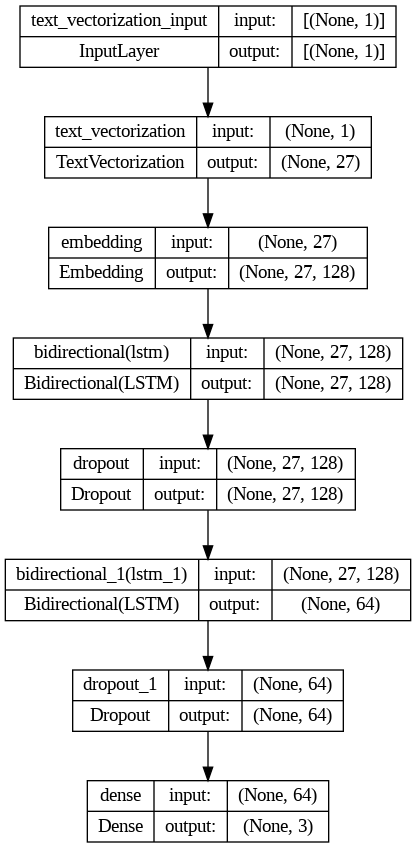

In [42]:
tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

In [43]:
# model training

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
657/657 [==============================] - 31s 31ms/step - loss: 0.8303 - accuracy: 0.6282 - val_loss: 0.7033 - val_accuracy: 0.7063
Epoch 2/25
657/657 [==============================] - 11s 16ms/step - loss: 0.5594 - accuracy: 0.7853 - val_loss: 0.7233 - val_accuracy: 0.7051
Epoch 3/25
657/657 [==============================] - 8s 12ms/step - loss: 0.3998 - accuracy: 0.8566 - val_loss: 0.8483 - val_accuracy: 0.6888
Epoch 4/25
657/657 [==============================] - 10s 15ms/step - loss: 0.2930 - accuracy: 0.8991 - val_loss: 1.0096 - val_accuracy: 0.6952
Epoch 5/25
657/657 [==============================] - 9s 13ms/step - loss: 0.2174 - accuracy: 0.9268 - val_loss: 1.1428 - val_accuracy: 0.6845
Epoch 6/25
657/657 [==============================] - 9s 13ms/step - loss: 0.1705 - accuracy: 0.9422 - val_loss: 1.3146 - val_accuracy: 0.6871
Epoch 7/25
657/657 [==============================] - 10s 16ms/step - loss: 0.1425 - accuracy: 0.9529 - val_loss: 1.4971 - val_accuracy: 0.

# vii. Model Evaluation

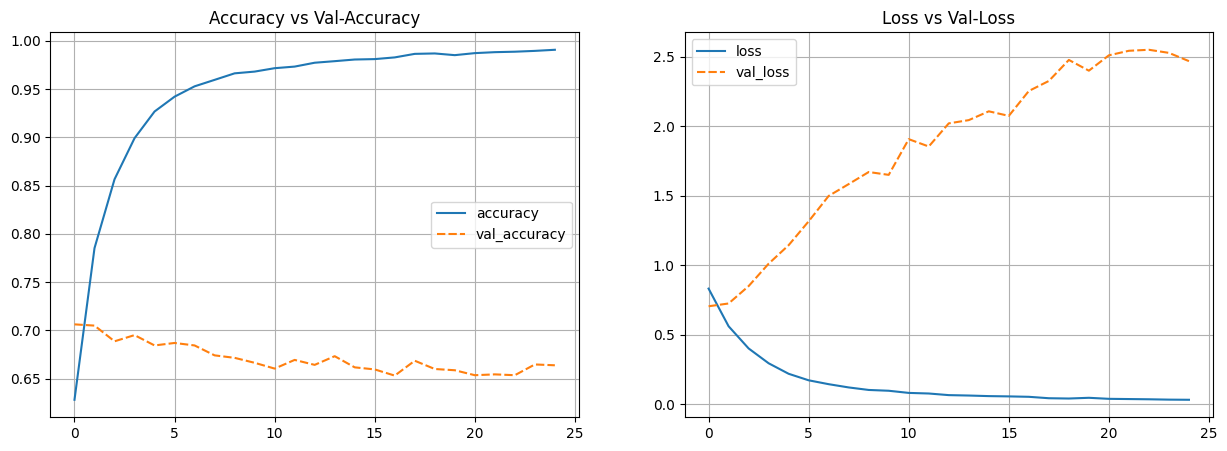

In [44]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [45]:
model_lstm_1_hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.830255,0.628229,0.703264,0.706336
1,0.559375,0.785310,0.723271,0.705051
2,0.399770,0.856572,0.848282,0.688784
3,0.293045,0.899148,1.009551,0.695205
4,0.217364,0.926787,1.142797,0.684503
5,0.170457,0.942153,1.314582,0.687072
6,0.142544,0.952857,1.497147,0.684503
7,0.119138,0.959564,1.582428,0.674229
8,0.101033,0.966319,1.669280,0.671661
9,0.095289,0.968127,1.648811,0.666524


In [46]:
# prediksi data test
y_pred = model_lstm_1.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)
y_pred

129/129 [==============================] - 3s 7ms/step


array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

In [47]:
print(classification_report(y_test_ohe, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62      1167
           1       0.60      0.66      0.63      1668
           2       0.70      0.66      0.68      1287

   micro avg       0.64      0.64      0.64      4122
   macro avg       0.65      0.63      0.64      4122
weighted avg       0.64      0.64      0.64      4122
 samples avg       0.64      0.64      0.64      4122



Model Analysis

Berikut adalah analisis singkat dari model_lstm_1 :

- Riwayat Pelatihan:

Riwayat pelatihan menunjukkan metrik loss dan akurasi untuk set pelatihan dan validasi selama beberapa epoch. Terlihat bahwa model dimulai dengan akurasi yang relatif tinggi dan loss yang rendah pada set pelatihan, tetapi mengalami peningkatan loss dan penurunan akurasi pada set validasi seiring waktu.

- Analisis Model:
- Kinerja Pelatihan:

Model mencapai akurasi tinggi pada set pelatihan, menunjukkan bahwa ia belajar dari data pelatihan. Namun, terdapat peningkatan loss dan penurunan akurasi pada set validasi, menunjukkan potensi masalah overfitting.

- Kinerja Validasi:

Kinerja model pada set validasi tidak sebaik pada set pelatihan, yang bisa menjadi tanda overfitting. Penurunan akurasi dan peningkatan loss pada set validasi dapat menunjukkan bahwa model tidak menggeneralisasi dengan baik ke data baru yang tidak terlihat.

- Matriks Konfusi (atau Laporan Klasifikasi): Matriks konfusi atau laporan klasifikasi memberikan informasi detail tentang kinerja model pada setiap kelas (0, 1, 2). Ini mencakup metrik seperti presisi, recall, dan skor F1 untuk setiap kelas, serta rata-rata makro dan berbobot. dengan rincian sebagai berikut :
- Precision (Presisi):
Untuk kelas 0, precision sekitar 0.66. Ini berarti dari semua yang diprediksi sebagai kelas 0 oleh model, sekitar 66% benar-benar adalah kelas 0.
Untuk kelas 1, precision sekitar 0.60, yang berarti dari semua yang diprediksi sebagai kelas 1 oleh model, sekitar 60% benar-benar adalah kelas 1.
Untuk kelas 2, precision sekitar 0.70, yang berarti dari semua yang diprediksi sebagai kelas 2 oleh model, sekitar 70% benar-benar adalah kelas 2.

- Recall (Recall atau Sensitivitas):
Untuk kelas 0, recall sekitar 0.58, yang berarti model dapat mengidentifikasi sekitar 58% dari semua instance yang seharusnya termasuk dalam kelas 0.
Untuk kelas 1, recall sekitar 0.66, yang berarti model dapat mengidentifikasi sekitar 66% dari semua instance yang seharusnya termasuk dalam kelas 1.
Untuk kelas 2, recall sekitar 0.66, yang berarti model dapat mengidentifikasi sekitar 66% dari semua instance yang seharusnya termasuk dalam kelas 2.

- F1-Score (Skor F1):
Untuk kelas 0, F1-score sekitar 0.62, yang merupakan harmonic mean dari precision dan recall untuk kelas tersebut.
Untuk kelas 1, F1-score sekitar 0.63.
Untuk kelas 2, F1-score sekitar 0.68.

- Support:
Support adalah jumlah instance sebenarnya yang termasuk dalam kelas tersebut di dataset.
Misalnya, kelas 0 memiliki support sebanyak 1167 instance dalam dataset.


### IMPROVMENT - BIDIRECTIONAL

Setelah melakukan train model kami belum mendapatkan hasil yang optimal sehingga kami mencoba melakukan improve dengan cara sebagai berikut.

In [48]:
# Download the Embedding Layer
url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [49]:
# Model Training using LSTM with Transfer Learning
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(3, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
657/657 [==============================] - 23s 26ms/step - loss: 1.0724 - accuracy: 0.4226 - val_loss: 1.0541 - val_accuracy: 0.4388
Epoch 2/25
657/657 [==============================] - 15s 23ms/step - loss: 1.0526 - accuracy: 0.4466 - val_loss: 1.0472 - val_accuracy: 0.4542
Epoch 3/25
657/657 [==============================] - 15s 23ms/step - loss: 1.0478 - accuracy: 0.4513 - val_loss: 1.0439 - val_accuracy: 0.4580
Epoch 4/25
657/657 [==============================] - 15s 23ms/step - loss: 1.0447 - accuracy: 0.4569 - val_loss: 1.0535 - val_accuracy: 0.4542
Epoch 5/25
657/657 [==============================] - 15s 23ms/step - loss: 1.0416 - accuracy: 0.4584 - val_loss: 1.0365 - val_accuracy: 0.4803
Epoch 6/25
657/657 [==============================] - 15s 23ms/step - loss: 1.0365 - accuracy: 0.4646 - val_loss: 1.0376 - val_accuracy: 0.4610
Epoch 7/25
657/657 [==============================] - 15s 23ms/step - loss: 1.0329 - accuracy: 0.4711 - val_loss: 1.0367 - val_accuracy:

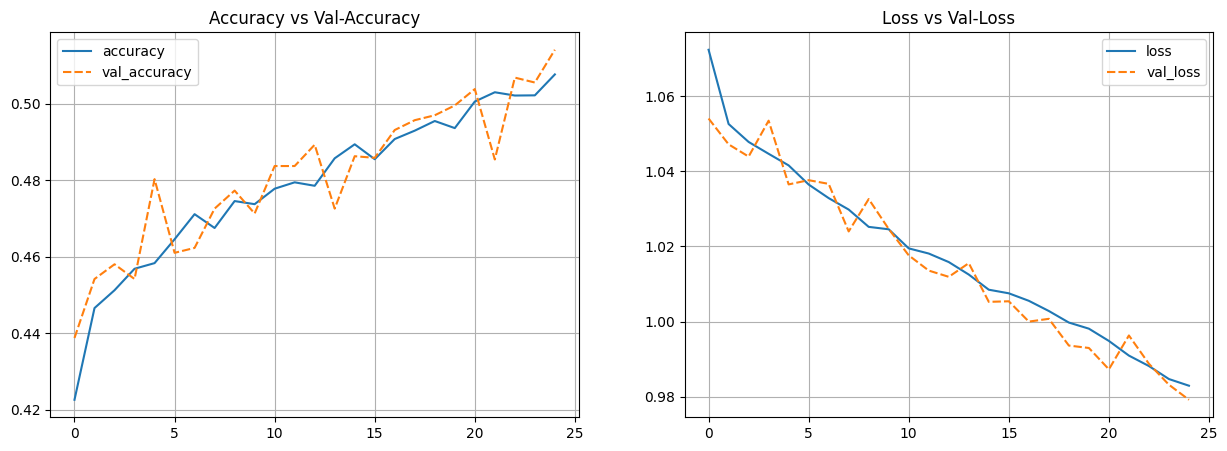

In [50]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [51]:
model_lstm_2_hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.072365,0.422625,1.054057,0.438784
1,1.052602,0.446601,1.047181,0.454195
2,1.047822,0.451263,1.043926,0.458048
3,1.044662,0.456876,1.053487,0.454195
4,1.041573,0.458351,1.036513,0.480308
5,1.036481,0.464583,1.037637,0.461045
6,1.032863,0.471148,1.036656,0.462329
7,1.029812,0.467532,1.023988,0.472603
8,1.025203,0.474573,1.032610,0.477312
9,1.024561,0.473764,1.024643,0.471318


In [60]:
y_pred_2 = model_lstm_2.predict(X_test)
y_pred_2 = np.where(y_pred_2 >= 0.5, 1, 0)
y_pred_2


129/129 [==============================] - 4s 31ms/step


array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 1]])

In [61]:
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 128, 64)           8704      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [62]:
print(classification_report(y_test_ohe, y_pred_2))

              precision    recall  f1-score   support

           0       0.58      0.10      0.17      1167
           1       0.56      0.24      0.34      1668
           2       0.65      0.36      0.46      1287

   micro avg       0.60      0.24      0.34      4122
   macro avg       0.60      0.23      0.32      4122
weighted avg       0.59      0.24      0.33      4122
 samples avg       0.24      0.24      0.24      4122



Analisis Model untuk model model_lstm_2

Kinerja Pelatihan dan Validasi:
- Model menunjukkan penurunan nilai loss pada set pelatihan dan validasi selama 25 epoch.
- Akurasi pada set pelatihan lebih tinggi daripada pada set validasi, menunjukkan adanya potensi overfitting.

Metric Klasifikasi:
- Performa model pada setiap kelas memiliki variasi yang signifikan.
Nilai precision, recall, dan f1-score untuk setiap kelas menunjukkan performa yang beragam, dengan beberapa kelas memiliki performa yang lebih baik daripada yang lain.

Dengan detail sebagaiberikut :

- Precision (Presisi):
Precision mengukur seberapa baik model dapat mengidentifikasi instance positif dari yang diprediksi positif.
Dalam konteks ini, untuk kelas 0 (label 0), precision sekitar 0.58, artinya dari semua yang diprediksi sebagai kelas 0 oleh model, sekitar 58% benar-benar adalah kelas 0.

- Recall (Recall atau Sensitivitas):
Recall mengukur seberapa baik model dapat menemukan semua instance positif yang seharusnya ditemukan.
Untuk kelas 1 (label 1), recall sekitar 0.24, yang berarti model hanya dapat mengidentifikasi sekitar 24% dari semua instance yang seharusnya termasuk dalam kelas 1.

- F1-Score (Skor F1):
F1-score adalah harmonic mean dari precision dan recall, memberikan nilai yang seimbang antara keduanya.
Untuk kelas 2 (label 2), F1-score sekitar 0.46, menggambarkan keseimbangan antara precision dan recall untuk kelas tersebut.

- Support:
Support adalah jumlah instance sebenarnya yang termasuk dalam kelas tersebut di dataset.
Misalnya, kelas 0 memiliki support sebanyak 1167 instance dalam dataset.

# viii. Model Saving

In [55]:
# Freeze Model
model_lstm_1.trainable = True

In [56]:
# simpan model
model_lstm_1.save('best_model')

In [57]:
#Nama direktori tempat menyimpan model
model_dir = 'best_model'

#Simpan model sebagai SavedModel TensorFlow
model_lstm_1.save(model_dir, save_format='tf')

#Kompres direktori model menjadi file ZIP
shutil.make_archive(model_dir, 'zip', model_dir)

#Mengunduh file ZIP model
files.download(f'{model_dir}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

freeze model berguna agar tidak ada parameter yang berubah lagi

# ix. Model Inference
Model inference berada pada file yang berebda dengan nama **Tweets.inf**

# x. Pengambilan Kesimpulan

Dari proses eksplorasi data sederhana didapatkan informasi :
- Dari pai chart diatas dari seluruh data dapat kita simpulkan sentiment negative = 28.32 %, sentiment positive = 31.23 %,
sentiment neutral = 40.45%.

- Dalam sentiment positif kata yang paling banyak muncul adalah  thank, love, happy, good dll
- Dalam sentiment negatif kata yang sering muncul adalah work, hate, miss, sad, suck dll
- Dalam sentimen netral kata kata yang sering muncul adalah day, one, new, time. today dll

Model yang di gunakan dalam machin learning memiliki performa yang relatif baik dengan nilai yang cukup tinggi pada precision, recall, dan F1-score untuk setiap kelas.
Keseragaman performa model pada setiap kelas menunjukkan kemampuan model untuk mengklasifikasikan instance dari setiap kelas dengan baik.
Namun, untuk evaluasi yang lebih mendalam, perlu diperhatikan karakteristik data dan mungkin dilakukan analisis lebih lanjut terhadap kasus-kasus spesifik yang mungkin memiliki kesulitan diidentifikasi oleh model.

Rekomendasi:
- Model masih terbilang overfitting sehingga dibutuhkan pertimbangan menerapkan  teknik-teknik untuk mengatasi overfitting, seperti dropout atau regularisasi.
Melakukan penyetelan hyperparameter atau eksperimen dengan arsitektur model yang berbeda.
Analisis lebih lanjut tentang data mungkin diperlukan untuk memahami lebih baik faktor-faktor yang mempengaruhi performa model.